# Youtube Channel Analysis: Outdoor Boys

## Background
**Outdoor Boys** is a popular YouTube channel that showcases a variety of outdoor activities, including camping, fishing, forging, and family adventures. The channel is run by Luke Nichols and his sons, Tommy, Nate, and Jacob. Since its launch, Outdoor Boys has amassed over 10 million subscribers, making it a significant presence in the outdoor and adventure genre on YouTube.

**Objective:**
Analyzing channel history and performance through video attributes.

In [66]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor

In [67]:
# data collected (re-ran) on feb 13th
df = pd.read_csv('./data/videos.csv')
channel_stats = pd.read_csv('./data/channel_stats.csv')
print(channel_stats)
df.head()

    channelName  subscribers       views  totalVideos  \
0  Outdoor Boys     13500000  2283815548          482   

                 playlistId  
0  UUfpCQ89W9wjkHc8J_6eTbBg  


,video_id,channelTitle,title,tags,publishedAt,viewCount,likeCount,commentCount,favoriteCount,duration,definition,caption
0,lgx6b0KhGKw,Outdoor Boys,Fight Ninja Discrimination - Magnetic Ninja Th...,"['DIY', 'Ninja', 'Ninja stars', 'Ninja throwin...",2018-11-17T12:13:06Z,380492,7269,NaN,0,PT7M36S,hd,False
1,zM-zBkE7qMg,Outdoor Boys,3 Days Stranded in Alaska's Bear Country - Cam...,"['Camping', 'survival', 'catch & cook', 'forag...",2023-05-27T11:00:42Z,8944284,115062,NaN,0,PT31M34S,hd,False
2,i8WgkpNLzVI,Outdoor Boys,Cooking Fat Back Bacon & Bread on Rock #cookin...,"['campfire cooking', 'survival cooking', 'bush...",2024-05-02T17:05:43Z,307892,12324,NaN,0,PT39S,hd,False
3,1CV-siC0JKQ,Outdoor Boys,🔴Live Backcountry Camping & Fishing,NaN,2019-05-24T23:53:27Z,159925,2651,NaN,0,PT21M20S,hd,False
4,Ga7MvmA8qPU,Outdoor Boys,Fishing with the family. Catching carp and fal...,"['Fishing', 'fishing with kids', 'fishing with...",2017-05-27T11:00:32Z,746693,6413,NaN,0,PT15M39S,hd,False


## Data Preprocessing

In [68]:
from isodate import parse_duration
from dateutil import parser

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       483 non-null    object 
 1   channelTitle   483 non-null    object 
 2   title          483 non-null    object 
 3   tags           465 non-null    object 
 4   publishedAt    483 non-null    object 
 5   viewCount      483 non-null    int64  
 6   likeCount      483 non-null    int64  
 7   commentCount   0 non-null      float64
 8   favoriteCount  483 non-null    int64  
 9   duration       483 non-null    object 
 10  definition     483 non-null    object 
 11  caption        483 non-null    bool   
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 42.1+ KB


In [70]:
df.drop(columns=['commentCount', 'caption', 'favoriteCount', 'channelTitle'], inplace=True)


**Reasons:**
- `commentCount`: Youtube bans comments on channels that feature minors to protect from harm. Therefore all videos have "0" comments.
-  `caption`: No video caption on any of his videos. Therefore, doesnt provide vairety
- `favoriteCount`: found out it is a depricated feature on Youtube, which is why all values are by default 0.
- `channelTitle`: Therefore no context is needed for which channel a video came from (as we are making an analysis about one channel)

In [71]:
# youtube ISO 8601 format to total seonds
df['duration'] = df['duration'].apply(lambda x: parse_duration(x).total_seconds())

# convert to datetime to get year, month, and day of the week the video was published
df['publishedAt'] = df['publishedAt'].apply(lambda x: parser.parse(x))
df['year'] = pd.to_numeric(df['publishedAt'].apply(lambda x: x.strftime('%y')))
df['month'] = pd.to_numeric(df['publishedAt'].apply(lambda x: x.strftime('%m')))
df['day_of_week'] = pd.Categorical(df['publishedAt'].apply(lambda x: x.strftime('%A')),
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                   ordered=True)

# get number of tags per video
df['num_tags'] = df['tags'].apply(lambda x: 0 if pd.isna(x) else len(x))

In [72]:
# rename & reorder attributes
df.columns = ['id', 'title', 'tags', 'published_date', 'num_views', 'num_likes', 'length', 'quality', 'year', 'month', 'day', 'num_tags']
df = df[['id', 'title', 'published_date', 'year', 'month', 'day', 'num_views', 'num_likes', 'length', 'quality', 'tags', 'num_tags']]

## Exploratory Data Analysis

For reference, here is a table of variable definitions:

| Variable    | Description |
| ----------- | ----------- |
| id       |  video id   |
| published_date   |  the date when video was published (year-month-day hour:minute:second+timezone)       |
| year   |    the year the video was published    |
| month   |   the month the video was published    |
| day   |   the day of the week the video was published      |
| num_views   |  the total number of views per video      |
| num_likes   |  the total number of likes per video      |
| length   |  the duration of video (in seonds)       |
| quality   |  video quality: either standard or high definition (sd, hd)    |
| tags   |  labels used for describing video content      |
| num_tags   |   the number of tags      |

### Matplotlib Configuration

In [73]:
# color pallete
red, orange, yellow, green, blue, purple = ('#ff6188', '#fc9867', '#ffd866', '#a8dd76', '#78dce8', '#ac9df2')
white, grey, black = ('#fcfcfa', '#2c2a2e', '#211f22')

# global params
matplotlib.rcParams['font.family'] = 'Georgia'
plt.rcParams['figure.facecolor'] = black
plt.rcParams['axes.facecolor'] = black
plt.rcParams['text.color'] = white
plt.rcParams['axes.labelcolor'] = white
plt.rcParams['xtick.color'] = white
plt.rcParams['ytick.color'] = white
matplotlib.rcParams['font.size'] = 12 


### 

### Behavioral Analysis: Looking into Content Strategies (Luke Nichols)

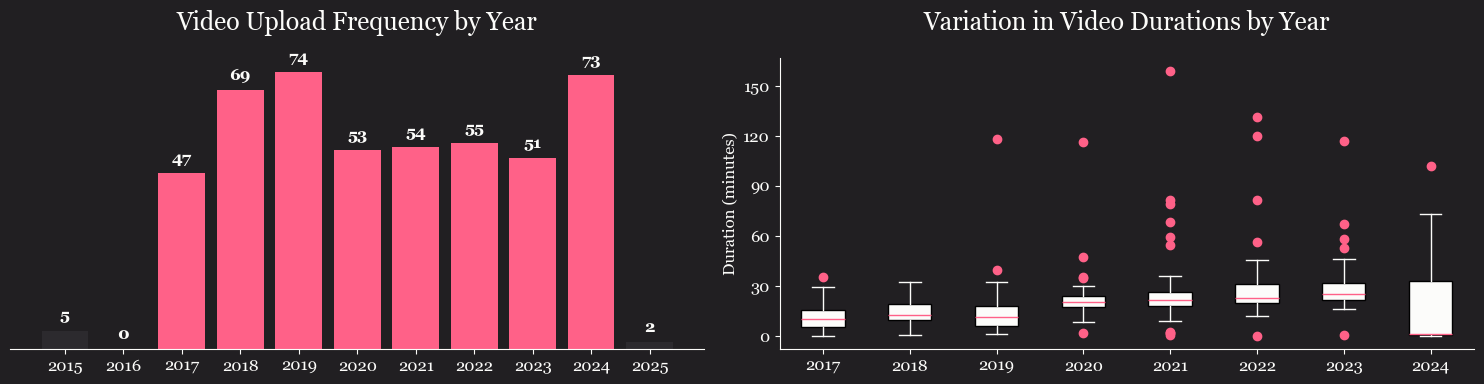

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

# bar plot
years = np.arange(15, 26)
year_value = df['year'].value_counts()
adj_year_value = year_value.reindex(year_value.index.append(pd.Index([16])), fill_value=0).sort_index() # since 2016 is missing
colors1 = [grey if (year == 15) or (year == 25) else red for year in adj_year_value.index]

bar = ax1.bar(years, adj_year_value, color=colors1)

ax1.bar_label(bar, color=white, padding=5, label_type='edge', fontweight='bold') # i need the bar object
ax1.set_title('Video Upload Frequency by Year', fontsize=18, pad=20)
ax1.yaxis.set_visible(False)
ax1.set_xticks(years)
ax1.set_xticklabels(adj_year_value.index + 2000)
ax1.spines[['bottom']].set_color(white)
ax1.spines[['top', 'right', 'left']].set_visible(False)

# boxplot
updated_years = np.arange(17, 25)
duration_yearly = [df.loc[df['year'] == x,'length']/60 for x in updated_years]
colors2 = 8 * [white]

bplot = ax2.boxplot(duration_yearly, patch_artist=True, flierprops=dict(markerfacecolor=red, markeredgecolor=red))

for patch, color in zip(bplot['boxes'], colors2):
    patch.set_facecolor(color)

for item in ['whiskers', 'fliers', 'caps', 'medians']:
    for box, c in zip(bplot[item], (14 * [white]) + (2 * [white])):
        if item == 'medians':
            box.set(color=red)
        else:
            box.set(color=c)

ax2.set_title('Variation in Video Durations by Year', fontsize=18, pad=20)
ax2.set_ylabel('Duration (minutes)')
ax2.set_yticks(np.arange(0, 180, 30))
ax2.set_xticklabels(2000 + updated_years)
ax2.spines[['top', 'right']].set_visible(False)
ax2.spines[['bottom', 'left']].set_color(white)

plt.tight_layout()
plt.show()

(CLEAR ANALYSIS NEEDED)

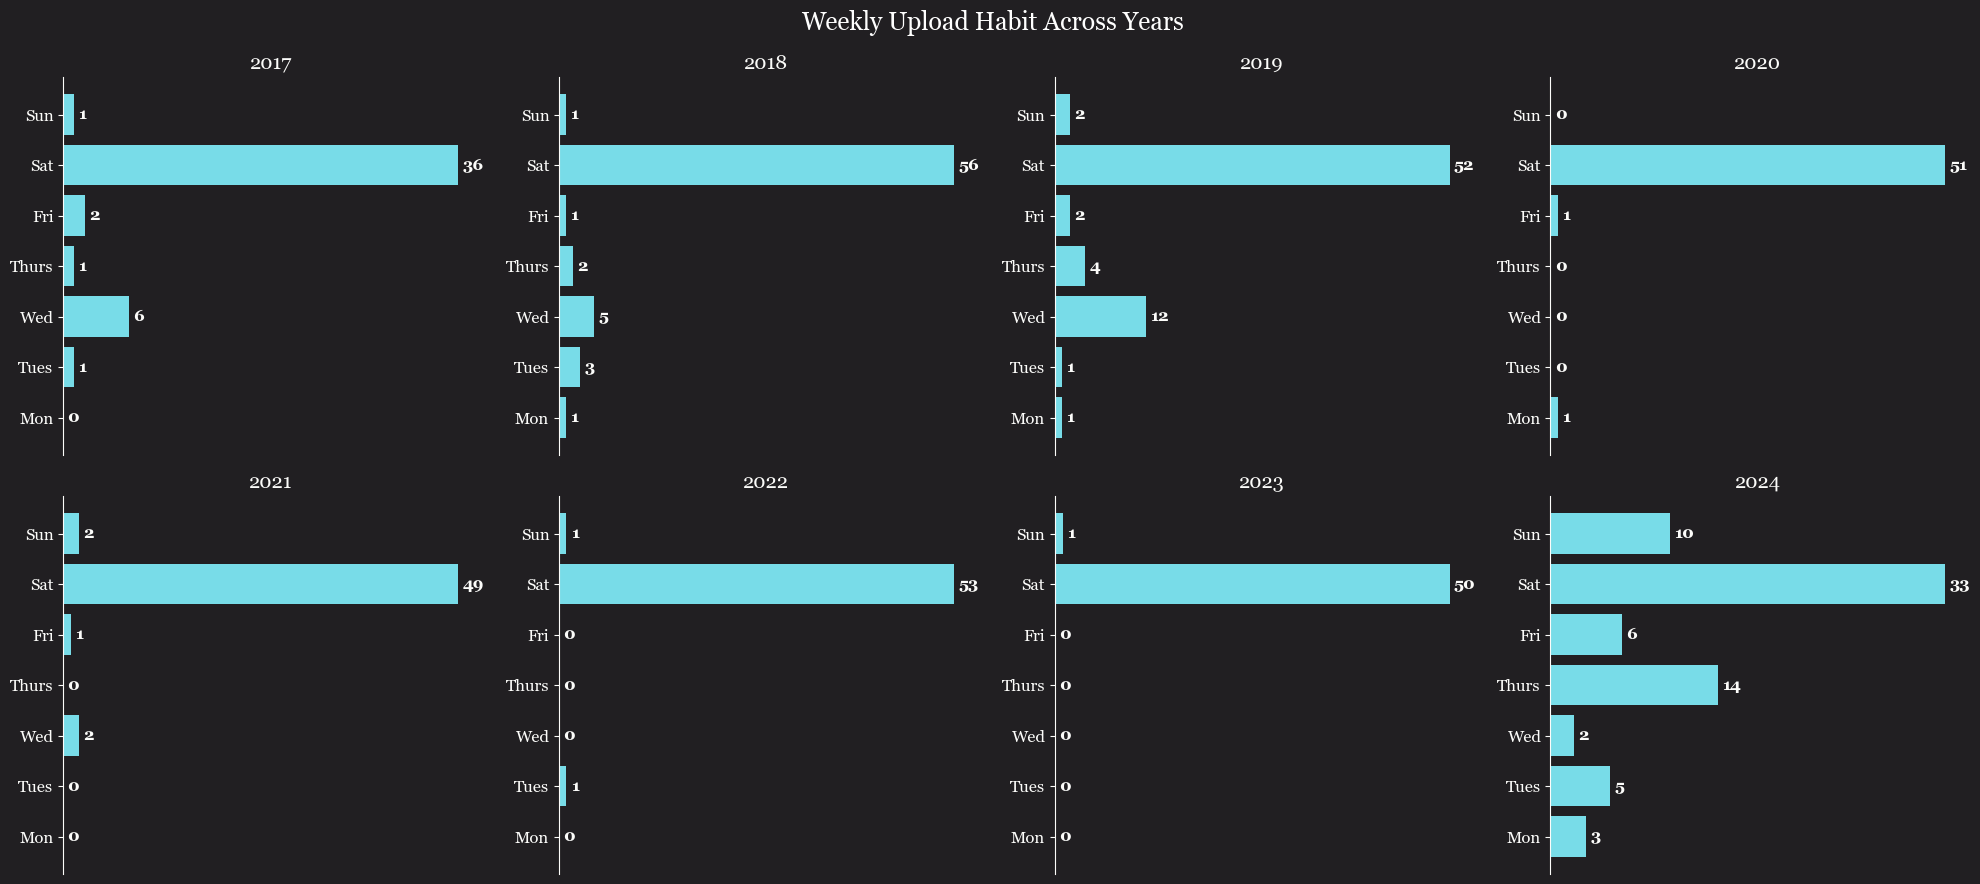

In [75]:
# weekly upload habit
fig, axes = plt.subplots(2,4, figsize=(20,9))
fig.suptitle('Weekly Upload Habit Across Years', fontsize=18, color='white')
years = np.arange(17,25)
u_years = years + 2000

i = 0
for row in axes:
    for ax in row:
        values = df.loc[df['year'] == years[i],'day'].value_counts().sort_index()
        bar = ax.barh(values.index, values, color=blue)
        ax.bar_label(bar, color=white, padding=3, label_type='edge', fontweight='bold')
        ax.set_title(u_years[i])
        ax.set_yticks(values.index)
        ax.set_yticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
        ax.xaxis.set_visible(False)
        ax.spines[['left']].set_color(white)
        ax.spines[['top', 'right', 'bottom']].set_visible(False)
        i+=1
plt.tight_layout()
plt.show()

### Comparative Analysis: Relationship Between Likes and Views (Random Sample Concensus)
A robust regression called `RANSACRegressor()` is used to ignore outliers and solely quantify the relationship between likes and views.

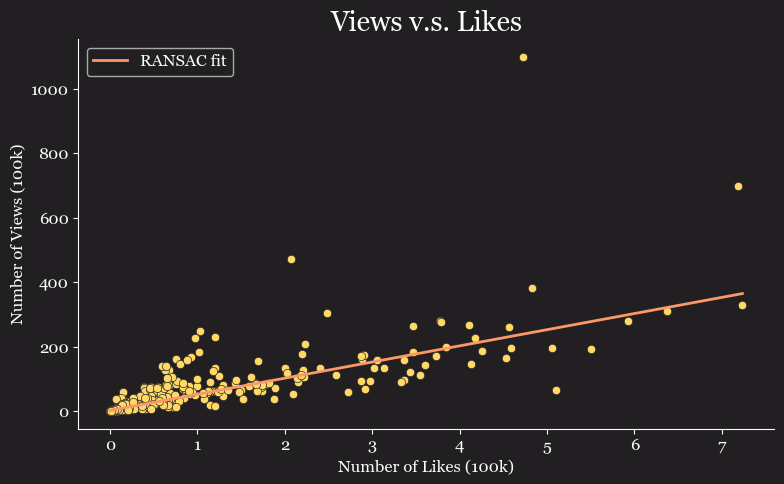

RANSAC fit slope: 50.18767582469379


In [76]:
ransac = RANSACRegressor()
x = df['num_likes'].values.reshape(-1, 1)
y = df['num_views'].values
ransac.fit(x, y)
x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)  
y_pred = ransac.predict(x_range)

fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(df['num_likes']/100_000, df['num_views']/100_000, color=yellow, edgecolors=grey, linewidths=0.5)
ax.plot(x_range/100_000, y_pred/100_000, color=orange, linewidth=2, label='RANSAC fit')

ax.set_title('Views v.s. Likes', fontsize=20)
ax.set_xlabel('Number of Likes (100k)')
ax.set_ylabel('Number of Views (100k)')

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(white)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print(f'RANSAC fit slope: {ransac.estimator_.coef_[0]}')

(CLEAR ANALYSIS)

#### 

### Time series analysis: Measuring Performance of Videos 

Normally, people use "*views*" to gage how well a video is doing. However, a view only means someone clicked on the video - it represents reach. It does not imply that they have fully watched it or enjoyed it. It could be due to an accidental click or inflated by inticing (called clickbait) titles/thumbnails. A "*like*" however, shows **active engagement**, often approval and satisfaction in the contents of the video. Therefore I am using `num_likes` as a metric to see how well Luke Nichols did on his youtube channel over the past 9 years.

In [77]:
df['outlier'] = False
for x in np.arange(17, 25):
    col = df.loc[df['year'] == x, 'num_likes']
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    df.loc[df['year'] == x, 'outlier'] = col > upper
print(f'# of outliers: {df['outlier'].sum()}')

# of outliers: 38


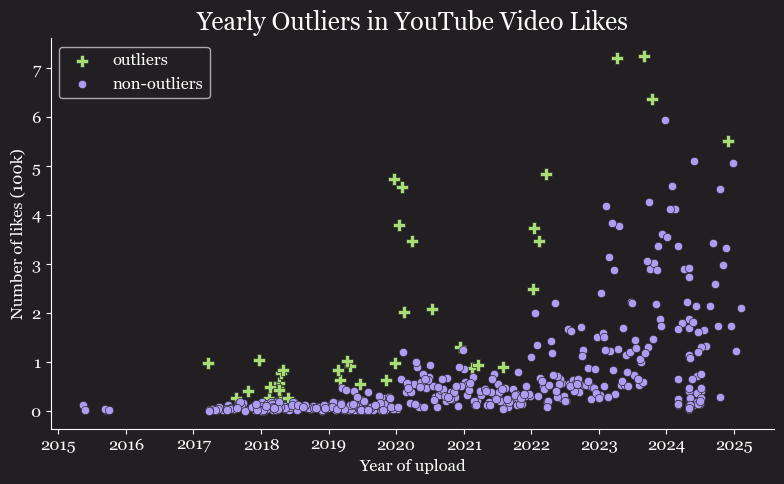

In [80]:
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(df.loc[df['outlier'] == True,'published_date'], df.loc[df['outlier'] == True, 'num_likes']/100_000, 
           color=green, label='outliers',
           marker='P',
           s=70,
           edgecolors=grey,
           linewidths=0.5)
ax.scatter(df.loc[df['outlier'] == False,'published_date'], df.loc[df['outlier'] == False, 'num_likes']/100_000,
           color=purple,
           label='non-outliers',
           edgecolors=grey,
           linewidths=0.5)

ax.set_title('Yearly Outliers in YouTube Video Likes', fontsize=18)
plt.legend(loc='upper left')
ax.set_ylabel('Number of likes (100k)')
ax.set_xlabel('Year of upload')

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(white)

plt.tight_layout()
plt.show()

In [82]:
df[df['year'] == 25]

,id,title,published_date,year,month,day,num_views,num_likes,length,quality,tags,num_tags,outlier
59,C-PW7lDl8g8,Exploring Every Island in Hawaii - 9 weeks fis...,2025-01-11 12:00:14+00:00,25,1,Saturday,6099338,121271,10964.0,hd,"['Fishing', 'Hawaii', 'Kauai', 'Fishing Hawaii...",521,False
385,mR3Smq_yBiA,Rebuilding Off-Grid Cabin & Digging Well at Al...,2025-02-08 12:01:05+00:00,25,2,Saturday,5281675,209237,2486.0,hd,"['Homestead', 'cabin', 'off-grid', 'off grid c...",533,False


(CLEAR ANALYSIS) Youtube recommends videos based on engagement metrics such as likes, comments, and shares. The more engagement, the more liekly the video will be reccomded to a bigger audience.
In this graph it shows.

## Summary